In [1]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [2]:
! pip install -q kaggle

In [3]:
! mkdir ~/.kaggle 

In [5]:
! chmod 600 ~/.kaggle/kaggle.json

In [6]:
!kaggle datasets download -d tanakritsaipahn/salmon-raw --unzip

 46% 5.00M/10.8M [00:00<00:00, 39.2MB/s]
100% 10.8M/10.8M [00:00<00:00, 74.3MB/s]


In [7]:
!pip install pytorch-lightning

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 701 kB 9.6 MB/s 
     |████████████████████████████████| 596 kB 59.0 MB/s 
     |████████████████████████████████| 141 kB 68.7 MB/s 
     |████████████████████████████████| 419 kB 70.4 MB/s 
     |████████████████████████████████| 5.9 MB 30.6 MB/s 
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.8.0
    Uninstalling tensorboard-2.8.0:
      Successfully uninstalled tensorboard-2.8.0
  Attempting uninstall: PyYAML
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.8.2+zzzcolab20220719082949 requires tensorboard<2.9,>=2.8, but you have tensorboard 2.10.0 which is inc

In [10]:
import pytorch_lightning as pl
import pandas as pd
import cv2
import os 
import torchvision
from torch import nn
from torch.utils.data import Dataset ,DataLoader, random_split
import numpy as np
import torch
from sklearn.model_selection import train_test_split 
from torchvision import transforms, datasets, models
import matplotlib.pyplot as plt
import torchmetrics
from torchmetrics.functional import accuracy
from pytorch_lightning.callbacks import LearningRateMonitor
from pytorch_lightning.callbacks.progress import TQDMProgressBar
from pytorch_lightning.loggers import CSVLogger
from torchvision.utils import make_grid
import math
import torch.nn.functional as F
from torchvision.ops import box_convert

In [11]:
from PIL import Image
from pycocotools.coco import COCO
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

In [57]:
class myOwnDataset(Dataset):
  def __init__(self, root, annotation, transforms=None):
    self.root = root
    self.transforms = transforms
    self.coco = COCO(annotation)
    self.ids = list(sorted(self.coco.imgs.keys()))

  def __getitem__(self, idx):
    # own coco file
    coco = self.coco
    # image ID
    img_id = self.ids[idx]
    # List: get annotation id from coco
    ann_ids = coco.getAnnIds(imgIds=img_id)
    # Dictionary: target coco_annotation file for an image
    coco_annotation = coco.loadAnns(ann_ids)
    # path for input image
    path = coco.loadImgs(img_id)[0]["file_name"]
    # open the input image
    img = Image.open(os.path.join(self.root, path))
    # number of objects in the image
    num_objs = len(coco_annotation)

    # bounding boxes for objects 
    # In coco format, bbox = [xmin, ymin, width, height]
    # In pytorch, the input should be [xmin, ymin, xmax, ymax]
    boxes = []
    for i in range(num_objs):
      xmin = coco_annotation[i]["bbox"][0]
      ymin = coco_annotation[i]["bbox"][1]
      width = coco_annotation[i]["bbox"][2]
      height = coco_annotation[i]["bbox"][3]
      boxes.append([xmin, ymin, width, height])
    boxes = torch.Tensor(boxes)
    # convert box format from "xywh" to "xyxy"
    boxes = box_convert(
                boxes, in_fmt="xywh", out_fmt="xyxy"
            )
    boxes = torch.as_tensor(boxes, dtype=torch.float32)
    # labels (In my case, I only one class: target class or background)
    labels = torch.ones((num_objs, ), dtype=torch.int64)
    # tensorize img_id
    img_id = torch.tensor([img_id])
    # size of bbox (rectangular)
    areas = []
    for i in range(num_objs):
      areas.append(coco_annotation[i]["area"])
    areas = torch.as_tensor(areas, dtype=torch.float32)
    # iscrowd
    iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

    # Annotation is in dictionary format
    my_annotation = {}
    my_annotation["boxes"] = boxes
    my_annotation["labels"] = labels
    my_annotation["image_id"] = img_id
    my_annotation["area"] = areas
    my_annotation["iscrowd"] = iscrowd

    if self.transforms is not None:
      img = self.transforms(img)

    return img, my_annotation

  def __len__(self):
    return len(self.ids)

In [58]:

# collate_fn needs for batch
def collate_fn(batch):
  return tuple(zip(*batch))

In [59]:
def get_model_instance_segmentation(num_classes):
  # load instance segmentation model pre-trained on COCO
  weights = models.detection.FasterRCNN_ResNet50_FPN_Weights.DEFAULT
  model = models.detection.fasterrcnn_resnet50_fpn(weights=weights)
  # get number of input features for the classifier
  in_features = model.roi_heads.box_predictor.cls_score.in_features
  # replace the pre-trained head with a new one
  model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

  return model

In [60]:
# path to my data and coco file
train_data_dir = "/content/train"
test_data_dir = "/content/test"
#val_data_dir = "/content/coco2017/val2017"
train_coco = "/content/train_annotations.coco.json"
test_coco = "/content/test_annotations.coco.json"

# batch size
train_batch_size = 16

# params for dataloader
train_shuffle_dl = True
val_shuffle_dl = False
test_shuffle_dl = False

# params for training

# two classes; only target class and background
num_classes = 2
num_epochs = 100

lr = 0.005
momentum = 0.9
weight_decay = 0.005

In [61]:
class LitDataModule(pl.LightningDataModule):
  def __init__(self):
    super().__init__()
    self.save_hyperparameters()
    #self.transform = self.get_transform()
    self.transform = transforms.ToTensor()

  def setup(self, stage=None):
    dataset = myOwnDataset(root=train_data_dir, annotation=train_coco, transforms=self.transform)
    self.test_dataset = myOwnDataset(root=test_data_dir, annotation=test_coco, transforms=self.transform)
    train_size = int(len(dataset)*0.9)
    val_size = len(dataset) - train_size
    self.train_dataset, self.val_dataset = random_split(dataset, [train_size, val_size])

  def train_dataloader(self):
    return DataLoader(self.train_dataset,
                      batch_size=train_batch_size,
                      shuffle=train_shuffle_dl,
                      collate_fn=collate_fn)
    
  def val_dataloader(self):
    return DataLoader(self.val_dataset,
                      batch_size=train_batch_size,
                      shuffle=val_shuffle_dl,
                      collate_fn=collate_fn)
    
  def test_dataloader(self):
    return DataLoader(self.test_dataset,
                      batch_size=train_batch_size,
                      shuffle=test_shuffle_dl,
                      collate_fn=collate_fn)
  

In [62]:
dm2 = LitDataModule()
dm2.setup()

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


In [63]:
ds_train = dm2.train_dataset
ds_val = dm2.val_dataset
len(ds_train)

317

In [64]:
len(ds_val)

36

In [65]:
len(dm2.test_dataset)

80

In [66]:
def f_beta(tp, fp, fn, beta=2):
    return (1+beta**2)*tp / ((1+beta**2)*tp + beta**2*fn+fp)

In [67]:
from torchmetrics.metric import Metric
from torchmetrics.detection.mean_ap import MeanAveragePrecision

In [68]:
class KaggleF2(Metric):
    def __init__(
        self,
        compute_on_step=True,
        dist_sync_on_step=False,
        process_group=None,
        dist_sync_fn=None,
    ) -> None:
        super().__init__(
            compute_on_step=compute_on_step,
            dist_sync_on_step=dist_sync_on_step,
            process_group=process_group,
            dist_sync_fn=dist_sync_fn,
        )

        self.add_state("detection_boxes", default=[], dist_reduce_fx=None)
        self.add_state("detection_scores", default=[], dist_reduce_fx=None)
        self.add_state("groundtruth_boxes", default=[], dist_reduce_fx=None)

    def update(self, preds, target):
        for item in preds:
            self.detection_boxes.append(
                torchvision.ops.box_convert(item["boxes"], in_fmt="xywh", out_fmt="xyxy")
                if len(item["boxes"]) > 0
                else item["boxes"]
            )
            self.detection_scores.append(item["scores"])

        for item in target:
            self.groundtruth_boxes.append(
                torchvision.ops.box_convert(item["boxes"], in_fmt="xywh", out_fmt="xyxy")
                if len(item["boxes"]) > 0
                else item["boxes"]
            )

    def compute(self):
        tps, fps, fns = 0, 0, 0
        for gt_boxes, pred_boxes, pred_scores in zip(
            self.groundtruth_boxes, self.detection_boxes, self.detection_scores
        ):
            tp, fp, fn = self._compute_stat_scores(gt_boxes, pred_boxes, pred_scores)
            tps += tp
            fps += fp
            fns += fn

        return f_beta(tps, fps, fns, beta=2)

    def _compute_stat_scores(self, gt_boxes, pred_boxes, pred_scores):
        if len(gt_boxes) == 0 and len(pred_boxes) == 0:
            tps, fps, fns = 0, 0, 0
            return tps, fps, fns

        elif len(gt_boxes) == 0:
            tps, fps, fns = 0, len(pred_boxes), 0
            return tps, fps, fns

        elif len(pred_boxes) == 0:
            tps, fps, fns = 0, 0, len(gt_boxes)
            return tps, fps, fns

        # sort by conf
        _, indices = torch.sort(pred_scores, descending=True)
        pred_boxes = pred_boxes[indices]

        tps, fps, fns = 0, 0, 0
        for iou_th in np.arange(0.3, 0.85, 0.05):
            tp, fp, fn = self._compute_stat_scores_at_iou_th(gt_boxes, pred_boxes, iou_th)
            tps += tp
            fps += fp
            fns += fn

        return tps, fps, fns

    def _compute_stat_scores_at_iou_th(self, gt_boxes, pred_boxes, iou_th):
        gt_boxes = gt_boxes.clone()
        pred_boxes = pred_boxes.clone()

        tp = 0
        fp = 0
        for k, pred_bbox in enumerate(pred_boxes):
            ious = torchvision.ops.box_iou(gt_boxes, pred_bbox[None, ...])

            max_iou = ious.max()
            if max_iou > iou_th:
                tp += 1
                
                # Delete max_iou box
                argmax_iou = ious.argmax()
                gt_boxes = torch.cat([gt_boxes[0:argmax_iou], gt_boxes[argmax_iou+1:]])
            else:
                fp += 1
            if len(gt_boxes) == 0:
                fp += len(pred_boxes) - (k + 1)
                break

        fn = len(gt_boxes)

        return tp, fp, fn

In [69]:
class LitModel(pl.LightningModule):
  def __init__(self):
    super().__init__()
    self.model = get_model_instance_segmentation(2)
    self.val_map = MeanAveragePrecision()
    self.val_f2 = KaggleF2()
    
  def forward(self, x):
    self.model.eval()
    x = self.model(x)
    return x

  def training_step(self, batch, batch_idx):
    imgs, annotations = batch
    loss_dict = self.model(imgs, annotations)
    losses = sum(loss for loss in loss_dict.values())
    
    batch_size = len(batch[0])
    self.log_dict(loss_dict, batch_size=batch_size)
    self.log("train_loss", losses, batch_size=batch_size)

    return losses

  def validation_step(self, batch, batch_idx):
    imgs, target = batch
    output = self.model(imgs)

    val_map = self.val_map(output, target)
    val_f2 = self.val_f2(output, target)

    self.log("val_map", val_map["map"])
    self.log("val_f2", val_f2)

  def test_step(self, batch, batch_idx):
    imgs, target = batch
    output = self.model(imgs)

    test_map = self.val_map(output, target)
    test_f2 = self.val_f2(output, target)

    self.log("test_map", test_map["map"])
    self.log("test_f2", test_f2)
     
  def configure_optimizers(self):
    params = [p for p in self.model.parameters() if p.requires_grad]
    optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

    lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

    return [optimizer], [lr_scheduler]

In [89]:
from pytorch_lightning.callbacks.early_stopping import EarlyStopping

dm = LitDataModule()
dm.setup()
model = LitModel()
trainer = pl.Trainer(max_epochs=num_epochs,
                  accelerator="auto",
                  devices=1 if torch.cuda.is_available() else None,
                  callbacks=[LearningRateMonitor(logging_interval="step"),
                                TQDMProgressBar(refresh_rate=5),
                             EarlyStopping(monitor="train_loss", mode="min")],
)


loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [90]:
trainer.fit(model, dm)

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name    | Type                 | Params
-------------------------------------------------
0 | model   | FasterRCNN           | 41.3 M
1 | val_map | MeanAveragePrecision | 0     
2 | val_f2  | KaggleF2             | 0     
-------------------------------------------------
41.1 M    Trainable params
222 K     Non-trainable params
41.3 M    Total params
165.197   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [91]:
trainer.validate(model, dm)

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
         val_f2             0.6444911360740662
         val_map            0.6376968026161194
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'val_map': 0.6376968026161194, 'val_f2': 0.6444911360740662}]

In [92]:
torch.save(model.state_dict(), './model.pth')

In [93]:
model2 = LitModel()
type(model2)


__main__.LitModel

In [94]:
model2.load_state_dict(torch.load("/content/model.pth"))
type(model2)

__main__.LitModel

In [95]:
trainer.test(model2, dm)

loading annotations into memory...
Done (t=0.02s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
         test_f2            0.6020299792289734
        test_map             0.622199296951294
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_map': 0.622199296951294, 'test_f2': 0.6020299792289734}]

In [27]:
import matplotlib.patches as patches
def plot_image(img_tensor, annotation):
    
    fig,ax = plt.subplots(1)
    img = img_tensor.cpu().data

    # Display the image
    ax.imshow(img.permute(1, 2, 0))
    
    for box in annotation["boxes"]:
        xmin, ymin, xmax, ymax = box.cpu().detach().numpy()
        # Create a Rectangle patch
        rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=1,edgecolor='r',facecolor='none')

        # Add the patch to the Axes
        ax.add_patch(rect)

    plt.show()

In [30]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
for imgs, annotations in dm.test_dataloader():
        imgs = list(img.to('cpu') for img in imgs)
        annotations = [{k: v.to('cpu') for k, v in t.items()} for t in annotations]
        break

In [ ]:
model.eval()
preds = model(imgs)
preds

Prediction


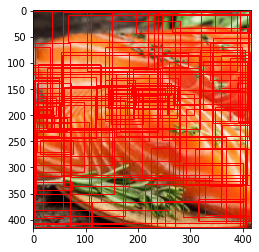

Target


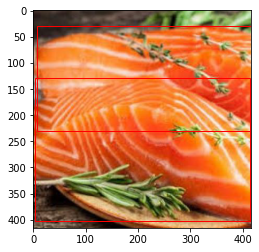

In [32]:
print("Prediction")
plot_image(imgs[2], preds[2])
print("Target")
plot_image(imgs[2], annotations[2])